In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, exp, pi, erfc
import scipy
from tqdm import tqdm
from scipy.integrate import simpson
import math

x_0_sampled = True

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.290153649828586e-06
_gain = np.sqrt(450696654238001.6)
_K = 6.746007702007992e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_eta = 0.32e-3
_gamma = 6 * np.pi * _r * _eta
z = 6*_r**2*np.sqrt(np.pi * _eta * _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, _m, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return _m*x0*a_inverse_form(t, roots) + _m*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

# THIS FUNCTION ASSUMES ZERO INITIAL VELOCITY
def v_t1_v_t2_zero_v0(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))

# This is the deterministic part of VACF with given v_0
def h_and_i(t, _m, v0, roots):
    return _m*v0*a_inverse_form(t, roots) #CANCELS + z*v0*s_half_b_inverse_form(t, roots)

#This function takes in v_0 - More general
def v_t1_v_t2(t1, t2, m, K, v0):
    return h_and_i(t1, m, v0, roots)*h_and_i(t2, m, v0, roots) + _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)


# History term in Laplace domain - see overleaf doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))


def cross_correlation(series1, series2, dt):
    if(len(series1) != len(series2)):
        print("series1 has " + str(len(series1)))
        print("series2 has " + str(len(series2)))
        return 0
    n = len(series1)
    cc = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in tqdm(np.array(range(1, n, 1))):
        cc_tau = series1[tau:]*series2[:n - tau]
        cc[tau] = np.mean(cc_tau)
    cc[0] = 0
    return cc, lag_times


def get_basset_int(a_series, start_idx):
    max_tau = start_idx
    lags = np.arange(1, max_tau+1)[::-1]/fs_sim
    basset_integral = []
    for curr_idx in tqdm(range(start_idx, len(a_series))):
        curr_integral = simpson(a_series[curr_idx-max_tau:curr_idx]/np.sqrt(lags), x=lags[::-1])
        basset_integral.append(curr_integral)
    return basset_integral


def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def get_acceleration(velocity, dt):
    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

Set v_0

In [2]:
v_not = 2 * np.sqrt(_k_b * _temp / _m)

Get the analytic form

In [3]:

times_analytic = np.logspace(-9, -1.5, 100)
roots = compute_roots(_m, _K, _r, _eta, _rho_f)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 10000


# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results_zero_no_half = np.zeros((num_samples, len(times_analytic)))
speeds_analytic = 0
zero_analytic = 0
if x_0_sampled:
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i], v_not)
        results_zero_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i],0)
    speeds_analytic=results_speed_no_half.mean(axis=0)
    zero_analytic=results_zero_no_half.mean(axis=0)
else:
    speeds_analytic = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, v_not)
    zero_analytic = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, 0)


PARAMS TO CHANGE

In [4]:
# High precision for inverse Laplace
mp.dps = 20

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1

# Number of tau points
N = 100

# Number of time (forward points)
points = 40


SETUP

In [5]:
# CHECK IF FILE EXISTS THEN RUN IF NEEDED
r_series = 0
positions = 0
velocities = 0
accelerations = 0

import os
chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

#Keep below 5
cut_factor = 1
bin_num_sim = 15

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)
length = len(positions_sim)
# CUT THE TRACES DOWN
positions_sim = [trace[:int(len(trace)/cut_factor)] for trace in positions_sim]
velocities_sim = [trace[:int(len(trace)/cut_factor)] for trace in velocities_sim]
# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

fs_sim = 1/(timestep_sim * bin_num_sim)
load=True
if os.path.exists("acceleration_and_random_force_etc.txt") and load:
    print("LOADING ACCELERATION AND RANDOM FORCE")
    # Load from text file
    loaded_data = np.loadtxt("acceleration_and_random_force_etc.txt", skiprows=1)  # Skip header

    # Extract columns
    accelerations = loaded_data[:, 0]
    velocities   = loaded_data[:, 1]
    positions     = loaded_data[:, 2]
    bass         = loaded_data[:, 3]
    r_series      = loaded_data[:, 4]


else:

    print("FINDING ACCELERATION AND RANDOM FORCE")

    traces_sim = []
    for trace in positions_sim:
        series = bin_data(trace, bin_num_sim)
        traces_sim.append(series)

    times = np.arange(len(traces_sim[0]))/fs_sim

    print("len of traces is " + str(len(traces_sim[0])))

    v_traces_sim = []
    for trace in velocities_sim:
        series = bin_data(trace, bin_num_sim)
        v_traces_sim.append(series)

    a_traces_sim = []
    for trace in v_traces_sim:
        series = get_acceleration(trace, times[1]-times[0])
        a_traces_sim.append(series)

    tau_max_idx = int(.001*fs_sim)
    bass = get_basset_int(a_traces_sim[0], tau_max_idx)
    r_series = []

    positions = np.array(traces_sim[0])[tau_max_idx:]
    velocities = np.array(v_traces_sim[0])[tau_max_idx:]
    accelerations = np.array(a_traces_sim[0])[tau_max_idx:]

    # We pick .001 as the max tau (how far back to begin calculating history - as it gives roughly 1% the value of 1/sqrt(1e-7) which is our min tau)

    r_series = _m*accelerations+_gamma*velocities+_K*positions+z*np.array(bass)


    data_to_save = np.column_stack((
        accelerations,
        velocities,
        positions,
        bass,
        r_series
    ))

    # Save to text file
    np.savetxt("acceleration_and_random_force_etc.txt", data_to_save, header="acceleration velocity position bass r_series")



LOADING ACCELERATION AND RANDOM FORCE


In [12]:
init_len_data = int(len(positions)/5000)
times = np.arange(len(positions))/fs_sim

std of data vel 0.0003111190930369911
speeds is 0.0006256857033698612
total idx data: 20550


100%|██████████| 20550/20550 [00:16<00:00, 1283.90it/s]


Finding avg
we summed 20550
-0.13898088265028374
Found avg


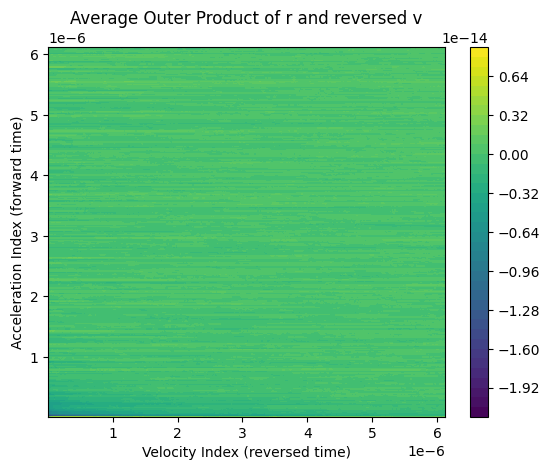

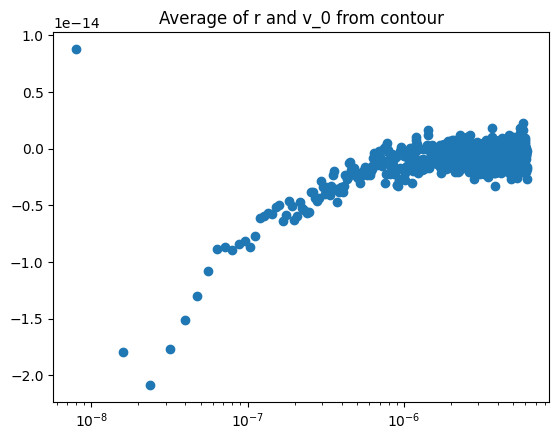

100%|██████████| 20550/20550 [00:00<00:00, 636622.43it/s]


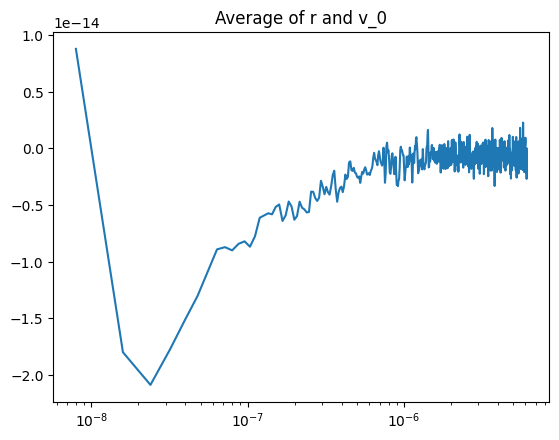

100%|██████████| 20550/20550 [00:00<00:00, 623101.06it/s]


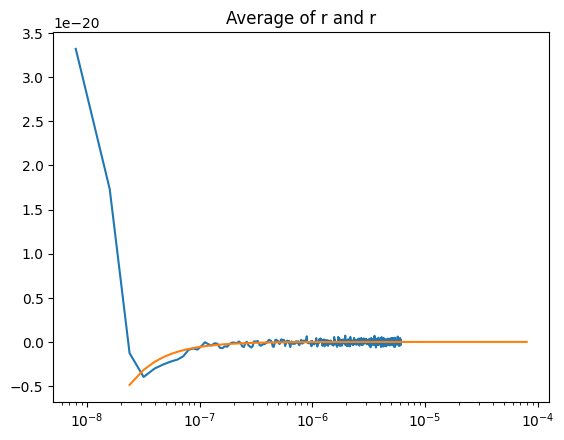

In [13]:
# But we want R(positive times) correlated with v(negative times)

# First, we condition around v_0

speeds = [v_not]
traces_per_speed = [0]

speeds_msds = []

speed_tol = [.05]

avg_contour_r_backward_v = 0
avg_r_v_0 = 0

for s in range(len(speeds)):

    speed_idxs_data = []
    print("std of data vel " + str(np.std(velocities)))
    print(f"speeds is {speeds[s]}")
    v_tolerance = (speeds[s])
    speed_tolerance = speed_tol[s]* np.sqrt(_k_b * _temp / _m)
    v_indices_data = np.where((velocities < (v_tolerance + speed_tolerance)) & (velocities > (v_tolerance - speed_tolerance)))[0]

    for idx in v_indices_data:
        if (idx + init_len_data < len(positions)) and (idx-init_len_data >= 0):
            speed_idxs_data.append(idx)

    print("total idx data: " + str(len(speed_idxs_data)))

    sum_ = np.zeros((init_len_data, init_len_data))
    i = 0
    for idx in tqdm(speed_idxs_data):
        sum_ += (np.outer(r_series[idx:idx+init_len_data], velocities[idx-init_len_data+1:idx+1][::-1]))#[idx:idx+init_len_data]
        i+=1

    X = np.arange(1, init_len_data+1)*1/fs_sim
    Y = np.arange(1, init_len_data+1)*1/fs_sim
    print("Finding avg")
    print("we summed " + str(i))
    print(accelerations[1]*velocities[1])
    avg_contour_r_backward_v = sum_/i
    print("Found avg")
    plt.contourf(X, Y, avg_contour_r_backward_v, levels=40)
    plt.title("Average Outer Product of r and reversed v")
    plt.colorbar()
    plt.xlabel("Velocity Index (reversed time)")
    plt.ylabel("Acceleration Index (forward time)")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.show()
    
    plt.scatter(X, avg_contour_r_backward_v[:,0])
    plt.title("Average of r and v_0 from contour")
    plt.xscale("log")
    # plt.yscale("log")
    plt.show()

    sum_term2_pt_2 = np.zeros(init_len_data)
    i_2_2 = 0
    for idx in tqdm(speed_idxs_data):
        sum_term2_pt_2 += r_series[idx:idx+init_len_data]*v_not
        i_2_2+=1

    X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
    avg_r_v_0 = sum_term2_pt_2/i_2_2
    plt.plot(X_2_2, avg_r_v_0)
    plt.title("Average of r and v_0")
    plt.xscale("log")
    # plt.yscale("log")
    plt.show()
    
    # RxR
    sum_rr = np.zeros(init_len_data)
    i_2_2r = 0
    for idx in tqdm(speed_idxs_data):
        sum_rr += r_series[idx:idx+init_len_data]*r_series[idx]
        i_2_2r+=1

    X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
    avg_r_r_0 = sum_rr/i_2_2r
    plt.plot(X_2_2, avg_r_r_0)
    plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
    plt.title("Average of r and r")
    plt.xscale("log")
    # plt.yscale("log")
    plt.show()


std of data vel 0.0003111190930369911
speeds is -0.0009385285550547918
total idx data: 1675


100%|██████████| 1675/1675 [00:00<00:00, 551968.82it/s]


std of data vel 0.0003111190930369911
speeds is 0.0
total idx data: 155085


100%|██████████| 155085/155085 [00:00<00:00, 657667.86it/s]


std of data vel 0.0003111190930369911
speeds is 0.0009385285550547918
total idx data: 1585


100%|██████████| 1585/1585 [00:00<00:00, 489181.15it/s]


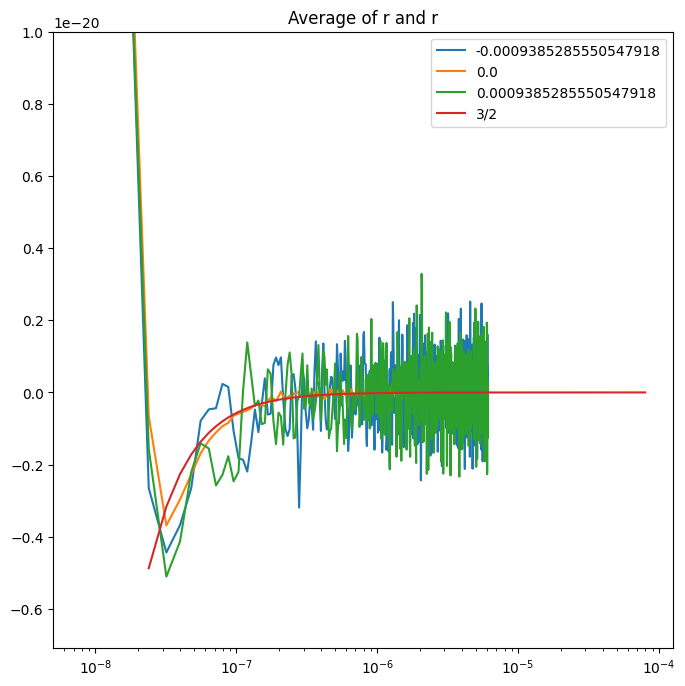

In [17]:

speeds2 = [ -3 * np.sqrt(_k_b * _temp / _m), -2 * np.sqrt(_k_b * _temp / _m),
          -1 * np.sqrt(_k_b * _temp / _m), 0 * np.sqrt(_k_b * _temp / _m), 1 * np.sqrt(_k_b * _temp / _m), 2 * np.sqrt(_k_b * _temp / _m),
          3 * np.sqrt(_k_b * _temp / _m)]
traces_per_speed = [0]

x_22s = []
speeds_rr = []

speed_tol = [.05, .05, .05, .05, .05, .05, .05]
plt.figure(figsize=(8,8))
for s in [0, 3, 6]:

    speed_idxs_data = []
    print("std of data vel " + str(np.std(velocities)))
    print(f"speeds is {speeds2[s]}")
    v_tolerance = (speeds2[s])
    speed_tolerance = speed_tol[s]* np.sqrt(_k_b * _temp / _m)
    v_indices_data = np.where((velocities < (v_tolerance + speed_tolerance)) & (velocities > (v_tolerance - speed_tolerance)))[0]

    for idx in v_indices_data:
        if (idx + init_len_data < len(positions)) and (idx-init_len_data >= 0):
            speed_idxs_data.append(idx)

    print("total idx data: " + str(len(speed_idxs_data)))

    # RxR
    sum_rr = np.zeros(init_len_data)
    i_2_2r = 0
    for idx in tqdm(speed_idxs_data):
        sum_rr += r_series[idx:idx+init_len_data]*r_series[idx]
        i_2_2r+=1

    X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
    avg_r_r_0 = sum_rr/i_2_2r
    x_22s.append(X_2_2)
    speeds_rr.append(avg_r_r_0)

    plt.plot(X_2_2, avg_r_r_0, label=f"{speeds2[s]}")
total_avg = np.mean(speeds_rr, axis=0)
# plt.plot(X_2_2, total_avg,linestyle='dashed',linewidth=2, label=f"TOTAL")
plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("Average of r and r")
plt.xscale("log")
plt.ylim(top=1e-20)
plt.legend()
plt.show()

Term 1 calculation

In [9]:
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace

t_evals = np.logspace(-8.25, -2, points)
msd_hs = []
count = 0

for t_eval in tqdm(t_evals):
    count +=1
    # Compute f(t, tau) for all tau
    f_vals = []
    for tau in tau_array:
        f_vals.append(f(t_eval, tau)) # tau is backwards time, t_eval is forwards
    fvals = np.array(f_vals)
    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = fvals[:, np.newaxis]
    f2 = fvals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K, v_not) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aproximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...
    # Integrate over tau1 and tau2
    msd_history = simpson(simpson(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)

100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


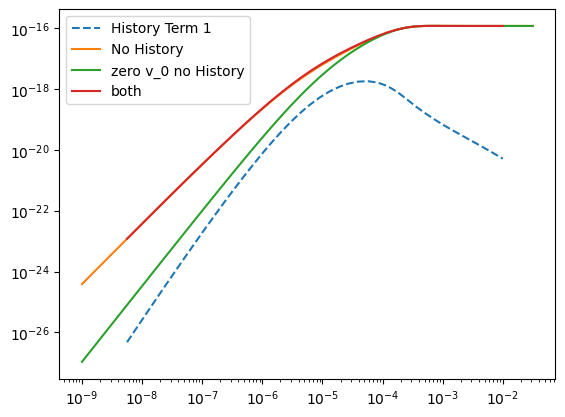

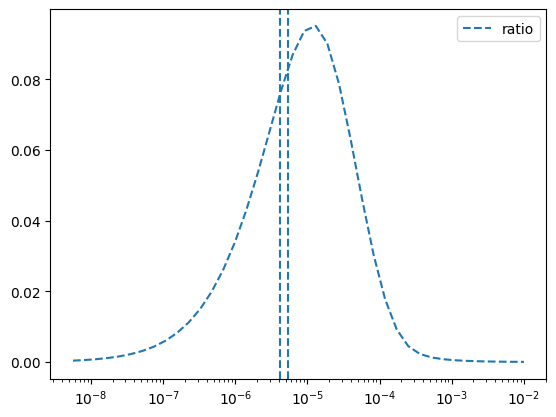

In [10]:
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(times_analytic, speeds_analytic, label = r"No History")
plt.plot(times_analytic, zero_analytic, label = r"zero v_0 no History")

tau_p_for_plot = _m/_gamma#3*np.pi*_r**2*_rho_f/_eta
tau_f_for_plot = _r**2*_rho_f/_eta
from scipy.interpolate import interp1d

intrp = interp1d(times_analytic, speeds_analytic)
analytic = intrp(t_evals)
plt.plot(t_evals, msd_hs+analytic, label = 'both')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t_evals, np.array(msd_hs)/np.array(analytic), linestyle='dashed', label="ratio")
plt.axvline(tau_p_for_plot, linestyle='dashed')
plt.axvline(tau_f_for_plot, linestyle='dashed')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

Term 2

In [11]:
inv_term2 = []
for tau in tqdm(tau_array):
    inv_term2.append([f(t, tau) for t in t_evals])

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


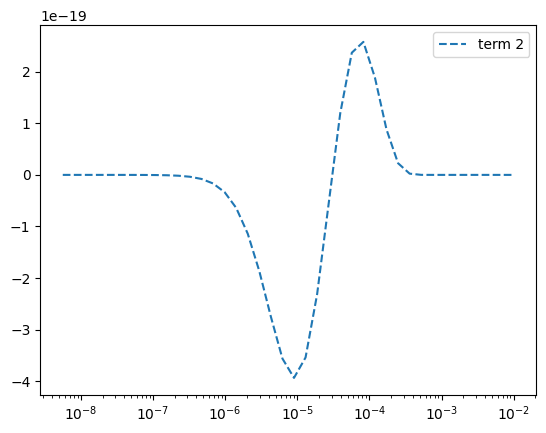

In [12]:
integrand = np.array(inv_term2)*_m*v_not**2*a_inverse_form(t_evals,roots)
#calcluate integral wrt tau to get out something as a func of t_evals
integral = simpson(integrand, tau_array, axis = 0)
#multiply by prefactor to get term2 result
term2 = -1*integral*_m*_gamma*_r*np.sqrt(_rho_f/(_eta*np.pi))*b_inverse_form(t_evals,roots) # this is the second b inverse form that technically has difference time

plt.plot(t_evals, term2, linestyle='dashed', label="term 2")
plt.xscale('log')
plt.legend()

In [13]:
# We are missing the second part of term 2 that goes like A(s)<v_0 R(s)>
# We can only calculate this with a convolution ...

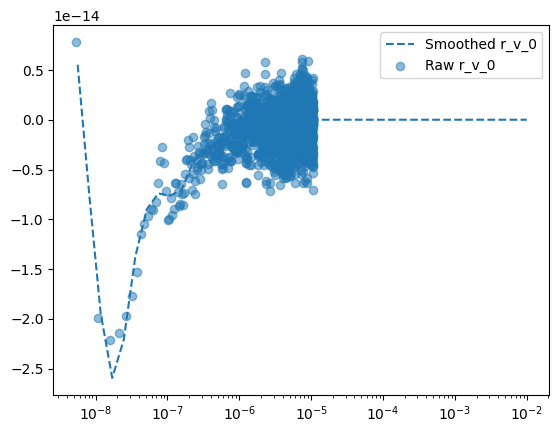

(100, 40)
(40,)


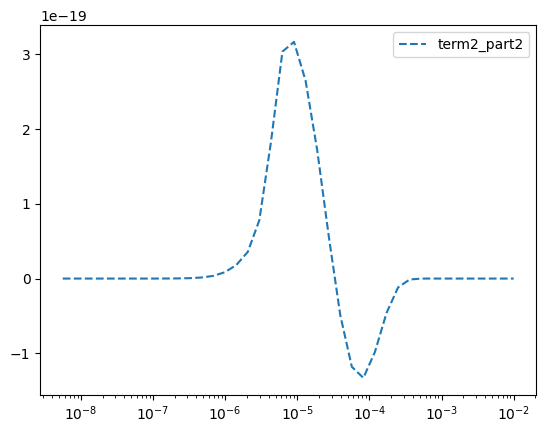

In [14]:
from scipy.interpolate import UnivariateSpline
import numpy as np

# Prevent zeros or negative values if any exist

x_fit = X_2_2
y_fit = avg_r_v_0

# Add custom weights to emphasize short times
# You can try 1/x, 1/x^2, or something smoother like exp(-x)
weights = 1 / x_fit  # Biases fit toward short times

# Fit smoothing spline with weights
spline_fit = UnivariateSpline(x_fit, y_fit, w=weights, s=.2e-12)

# Interpolation points
r_v_0 = np.zeros_like(t_evals)

# Define valid bounds
valid_mask = (t_evals >= x_fit.min()) & (t_evals <= x_fit.max())

# Evaluate only in bounds, zero elsewhere
r_v_0[valid_mask] = spline_fit(t_evals[valid_mask])

# Plot
plt.plot(t_evals, r_v_0, label='Smoothed r_v_0', linestyle='dashed')
plt.scatter(X_2_2, avg_r_v_0, alpha=0.5, label='Raw r_v_0')
plt.xscale('log')
plt.legend()
plt.show()

res_conv = []

for t in t_evals:
    t_sized = t_evals[t_evals<=t]
    integrand_conv = r_v_0[:len(t_sized)]*a_inverse_form(t-t_sized,roots)
    integral_conv = simpson(integrand_conv,t_sized)
    res_conv.append(integral_conv)

inv_term2 = np.array(inv_term2)
res_conv = np.array(res_conv)
print(inv_term2.shape) #(31, 30)
print(res_conv.shape) #(31,)
part2_integrand = inv_term2*res_conv[None,:]
integral_part2 = simpson(part2_integrand, tau_array, axis = 0)
term2_part2 = -integral_part2*_m*_gamma*_r*np.sqrt(_rho_f/(_eta*np.pi))*b_inverse_form(t_evals,roots)


plt.plot(t_evals, term2_part2, linestyle='dashed', label="term2_part2")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


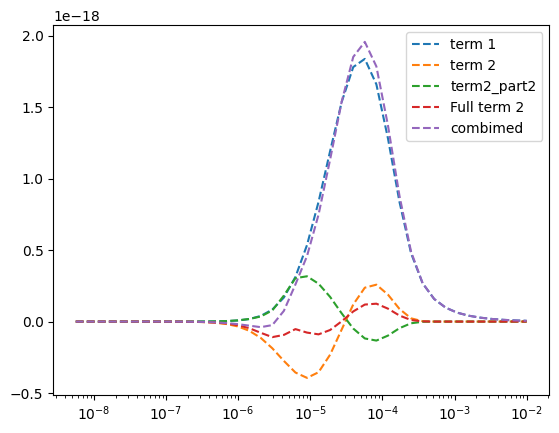

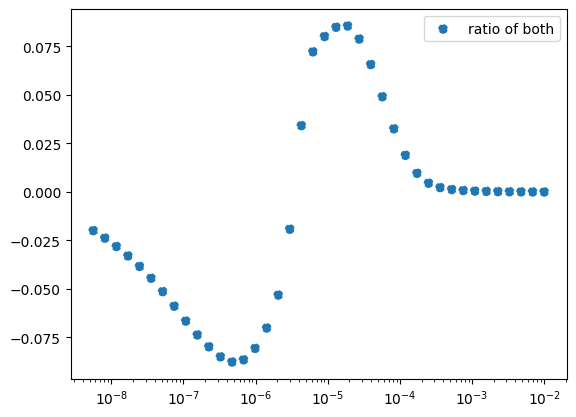

In [15]:

plt.plot(t_evals, msd_hs, linestyle='dashed', label="term 1")
plt.plot(t_evals, term2, linestyle='dashed', label="term 2")
plt.plot(t_evals, term2_part2, linestyle='dashed', label="term2_part2")
plt.plot(t_evals, term2+term2_part2, linestyle='dashed', label="Full term 2")
plt.plot(t_evals, msd_hs+term2+term2_part2, linestyle='dashed', label="combimed")
# plt.plot(times_analytic, speeds_analytic, label = r"No History")
# plt.plot(times_analytic, zero_analytic, label = r"zero v_0 no History")
plt.plot()
plt.xscale('log')
plt.legend()
plt.show()

plt.scatter(t_evals, np.array(msd_hs+term2+term2_part2)/np.array(analytic), linestyle='dashed', label="ratio of both")
plt.plot()
plt.xscale('log')
plt.legend()
plt.show()

Term 3

TERM 3

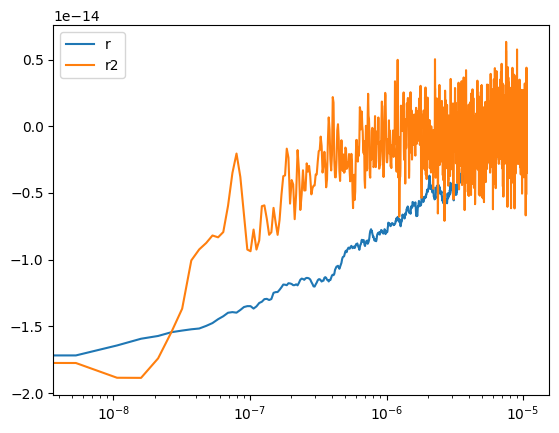

  2%|▎         | 1/40 [00:55<35:52, 55.18s/it]


KeyboardInterrupt: 

In [16]:
# What we really want to calculate is z*int(g(tau, s')*<R(s)v(tau)>dtau)
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import math

mp.dps = 30

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _eta, _rho_f)

# lets implement the slide that involves the  correlation function

# <r v>
r_v = avg_contour_r_backward_v

# how to acces r_v slice at tau (vel = tau')............r_v[tau_time]???????????? no
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[5, :], label="r") # Wrong
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[:, 5], label="r2") # Correct
plt.xscale("log")
plt.legend()
plt.show()

# inner intergral over t' # Need to loop this over taus
def inner_int_as_func_tau(t_2, taus):
    ret = []
    t_prime_full = np.arange(1, init_len_data+1)*1/fs_sim
    t_prime = t_prime_full[t_prime_full <= t_2]
    for tau_time in taus:
        integrand = np.array(r_v[:,int(tau_time*fs_sim)][:len(t_prime)])*np.array(b_inverse_form(t_2 - np.array(t_prime), roots))
        total = simpson(integrand, t_prime)
        ret.append(total)
    return np.array(ret)

def outer_int(t_1, t_2):
    # tau is supppose to go from -inf to zero, we need it to match the contour
    taus = -np.arange(1, init_len_data+1)[::-1]*1/fs_sim
    prod1 = []
    for tau in taus:
        prod1.append(f(t_1, tau))
    integrand = np.array(prod1)*inner_int_as_func_tau(t_2, taus)
    total = simpson(integrand, taus)
    return total

def get_r_cross_term(t_1, t_2):
    z = 6*_r**2*np.sqrt(np.pi*_eta*_rho_f)
    r_cross_v_term = (z * outer_int(t_1, t_2))
    return -1 * r_cross_v_term

results = [get_r_cross_term(t, t) for t in tqdm(t_evals)]



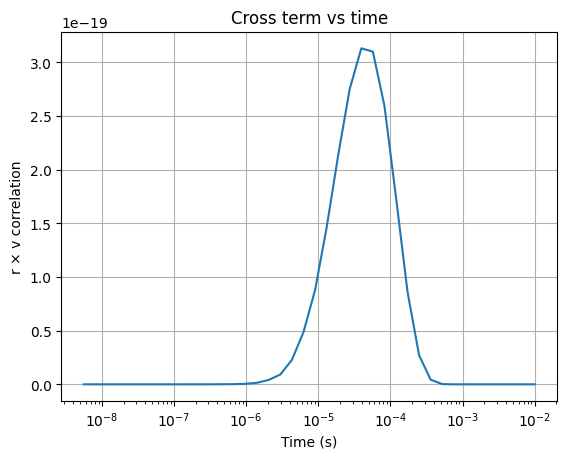

In [16]:

plt.plot(t_evals, results)
plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("r × v correlation")
plt.title("Cross term vs time")
plt.grid(True)
plt.show()

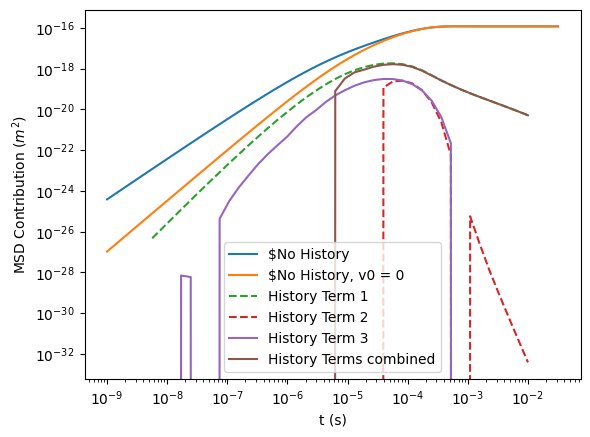

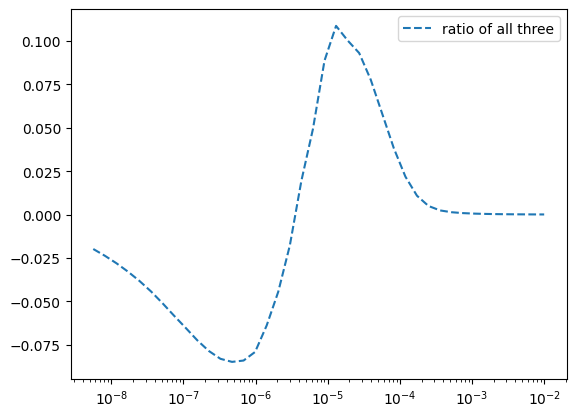

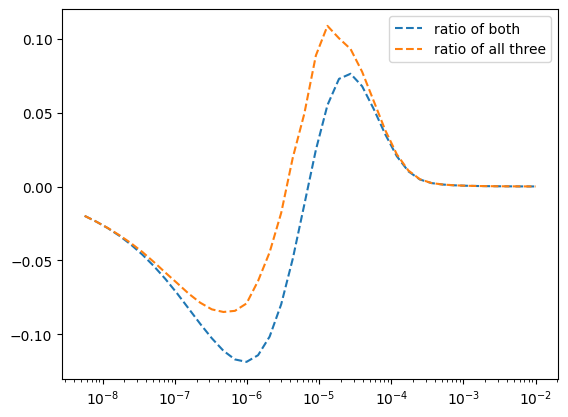

In [17]:

plt.plot(times_analytic, speeds_analytic, label = r"$No History")
plt.plot(times_analytic, zero_analytic, label = r"$No History, v0 = 0")
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(t_evals, term2, linestyle='dashed', label="History Term 2")
plt.plot(t_evals, results, label = "History Term 3")
plt.plot(t_evals, msd_hs+term2+term2_part2-results, label = "History Terms combined")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("t (s)")
plt.ylabel(r"MSD Contribution $(m^2)$")
plt.legend()
plt.show()

plt.plot(t_evals, np.array(msd_hs+term2+term2_part2+results)/np.array(analytic), linestyle='dashed', label="ratio of all three")
plt.plot()
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t_evals, np.array(msd_hs+term2)/np.array(analytic), linestyle='dashed', label="ratio of both")
plt.plot(t_evals, np.array(msd_hs+term2+term2_part2+results)/np.array(analytic), linestyle='dashed', label="ratio of all three")
plt.plot()
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

#